In [111]:
# Define autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
# updated loss function since the final batch may have difference size
# made l_constraint a tensor instead of converting to scalar
# tested for overfitting

from training_defs import load_spectral_data, get_dataloaders
from model import MLP
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

X, y = load_spectral_data()
train_loader, val_loader = get_dataloaders(X, y)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hidden_layers = [64]                  # very shallow
# hidden_layers = [128, 128]            # shallow
# hidden_layers = [256]*3               # medium
hidden_layers = [256]*4               # deeper
# hidden_layers = [256]*5               # deeper
# hidden_layers = [512]*8               # very deep
# hidden_layers = [128, 64, 32]         # funnel
# hidden_layers = [32, 64, 128]    # reverse funnel

print("Testing config:", hidden_layers)
model = MLP(in_dim=X.shape[1], h_dim=hidden_layers, out_dim=3).to(device)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 200
lconst_mult = 0

# early-stopping setup
# best_val  = float('inf')
# patience = 10
# no_improve = 0

train_losses, val_losses = [], []


Testing config: [256, 256, 256, 256]


In [243]:
for epoch in range(1, n_epochs+1):
    model.train()
    tot_train = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        preds = model(xb)
        loss_pred = criterion(preds, yb)
        # keep this as a tensor so autograd tracks it
        l_constraint = ((preds[0].sum() + preds[1].sum()) - 2) ** 2

        loss = loss_pred + lconst_mult * l_constraint
        loss.backward()
        optimizer.step()

        tot_train += loss.item() * xb.size(0)

    train_losses.append(tot_train / len(train_loader.dataset))

    model.eval()
    tot_val = 0.0
    n_seen  = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            batch_sz = xb.size(0)
            val_pred = model(xb)
            loss_b = criterion(val_pred, yb)
            tot_val += loss_b.item() * batch_sz
            n_seen += batch_sz
    val_losses.append(tot_val / n_seen)

    print(f"epoch {epoch:02d}  train loss: {train_losses[-1]:.4f}  val loss: {val_losses[-1]:.4f}")


    # current_val = val_losses[-1]
    # if current_val < best_val:
    #     best_val   = current_val
    #     no_improve = 0
    #     # save best model checkpoint
    #     torch.save(model.state_dict(),
    #             f"best_model_{'_'.join(map(str,hidden_layers))}.pth")
    # else:
    #     no_improve += 1
    #     if no_improve >= patience:
    #         print(f"Stopping early at epoch {epoch}")
    #         break

epoch 01  train loss: 0.2161  val loss: 0.1753
epoch 02  train loss: 0.1750  val loss: 0.1567
epoch 03  train loss: 0.1542  val loss: 0.1602
epoch 04  train loss: 0.1428  val loss: 0.1390
epoch 05  train loss: 0.1368  val loss: 0.1466
epoch 06  train loss: 0.1232  val loss: 0.1207
epoch 07  train loss: 0.1146  val loss: 0.1352
epoch 08  train loss: 0.1078  val loss: 0.1157
epoch 09  train loss: 0.1034  val loss: 0.1384
epoch 10  train loss: 0.1071  val loss: 0.1186
epoch 11  train loss: 0.0943  val loss: 0.1047
epoch 12  train loss: 0.1006  val loss: 0.0914
epoch 13  train loss: 0.0918  val loss: 0.1317
epoch 14  train loss: 0.1022  val loss: 0.0882


KeyboardInterrupt: 

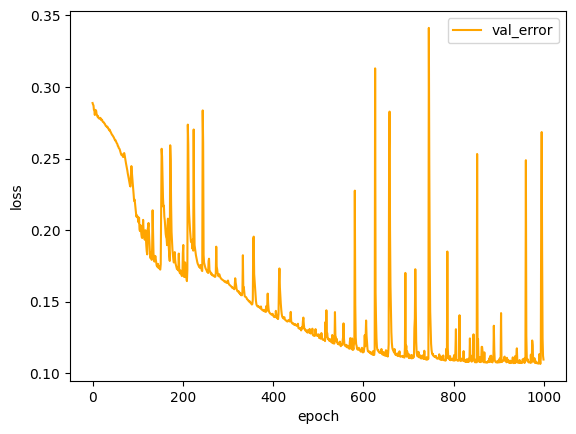

In [238]:
# plt.plot(train_losses, label="train")
plt.plot(val_losses, color='orange', label="val_error")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()

torch.save(model.state_dict(), "spectra_mlp.pth")

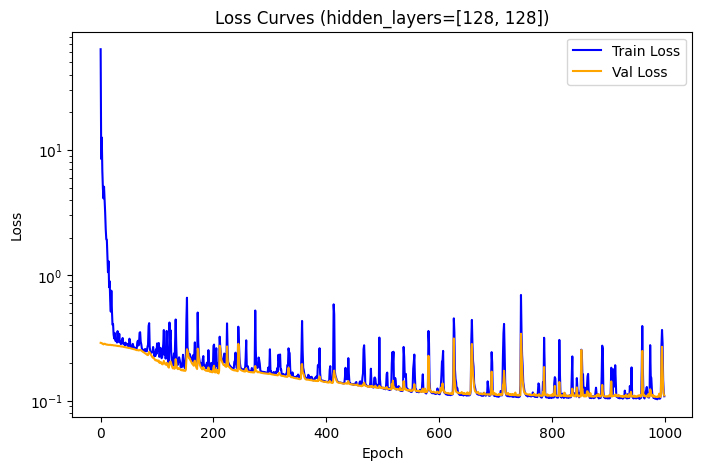

In [239]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, color="blue",   label="Train Loss")
plt.plot(val_losses,   color="orange", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title(f"Loss Curves (hidden_layers={hidden_layers})")
plt.legend()
plt.show()

torch.save(model.state_dict(), f"spectra_mlp_{'_'.join(map(str,hidden_layers))}.pth")

In [241]:
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

r2 = r2_score(all_targets, all_preds, multioutput="uniform_average")
rmse = root_mean_squared_error(all_targets, all_preds)
gap = val_losses[-1] - train_losses[-1]
rel = gap / train_losses[-1] * 100

print(f"validation r^2:  {r2:.4f}")
print(f"validation rmse: {rmse:.4f}")
print(f"abs final gap (val–train) = {gap:.4f}")
print(f"rel final gap ((val–train) / train) = {rel:.4f}")

validation r^2:  0.6663
validation rmse: 0.1673
abs final gap (val–train) = 0.0015
rel final gap ((val–train) / train) = 1.3980
